In [57]:
import math
import numpy as np
import pandas as pd
import itertools
import joblib
from copy import deepcopy
import matplotlib.pyplot as plt
import networkx
import time
import networkx as nx
%matplotlib inline

In [82]:
def plot_fitness_time(solutions, fitness):
    times = [sol[2] for sol in solutions]
    costs = [sol[0] for sol in solutions]
    plt.figure(figsize=(10, 8))
    plt.ylabel('Fitness ({})'.format(fitness))
    plt.xlabel('Time (s)')
    #plt.title('QSD for {} with {}'.format(city, alg))
    #plt.ylim(0, 1)
    plt.grid(True)
    plt.plot(times, costs)

In [8]:
def head(X, b):
    heads = 0
    i = 0
    while i < len(X) and X[i] == b:
        heads += 1
        i += 1
    return heads

In [9]:
def tail(X, b):
    tails = 0
    j = len(X) - 1
    while j > -1 and X[j] == b:
        tails += 1
        j -= 1
    return tails

In [10]:
def r(X, T):
    return (tail(X, 0) > T and head(X, 1) > T) * len(X)

In [11]:
def four_peaks(X, T):
    return max(tail(X, 0), head(X, 1)) + r(X, T)

In [12]:
def get_labels(pop, x):
    return list(set(pop[:, x]))

In [13]:
def probability(pop, x, x_label):
    return sum(pop[:, x] == x_label) / len(pop[:, x])

In [14]:
def conditional_probability(pop, x, x_label, y, y_label):
    try:
        return sum(pop[pop[:, y] == y_label][:, x] == x_label) / len(pop[pop[:, y] == y_label][:, x])
    except ZeroDivisionError:
        return 0

In [15]:
def entropy(pop, x):
    h = 0
    labels = get_labels(pop, x)
    for label in labels:
        p_x = probability(pop, x, label)
        if p_x == 0:
            h -= 0
        else:
            h -= p_x * np.log(p_x)
    return h

In [16]:
def conditional_entropy(pop, x, y):
    h = 0
    x_labels = get_labels(pop, x)
    y_labels = get_labels(pop, y)
    for y_label in y_labels:
        h_cond = 0
        #p_y = sum(pop[:, y] == y_label) / len(pop[:, y])
        p_y = probability(pop, y, y_label)
        for x_label in x_labels:
            #p_x = sum(pop[pop[:, y] == y_label][:, x] == x_label) / len(pop[pop[:, y] == y_label][:, x])
            #p_x = sum(pop[pop[:, y] == y_label][:, x] == x_label) / len(pop[:, x])
            p_x = conditional_probability(pop, x, x_label, y, y_label)
            if p_x == 0:
                h_cond -= 0
            else:
                h_cond -= p_x * np.log(p_x)
        if p_y == 0:
            h += 0
        else:
            h += p_y * h_cond
    return h

In [17]:
def mutual_information(pop, x, y):
    return entropy(pop, x) - conditional_entropy(pop, x, y)

In [18]:
def dependency_tree(pop, N):
    graph = nx.Graph()
    for u, v in itertools.combinations(range(N), 2):
        graph.add_edge(u, v, weight=-mutual_information(pop, u, v))
    mst = nx.minimum_spanning_tree(graph)
    root = np.argmax([len(mst[n]) for n in mst.nodes])
    return list(nx.dfs_edges(mst, root))

In [19]:
def generate_sample(pop, N, d_tree):
    sample = np.zeros(N)
    root = d_tree[0][0]
    prob = [probability(pop, root, label) for label in get_labels(pop, root)]
    sample[root] = np.random.choice(get_labels(pop, root), p=prob)
    for y, x in d_tree:
        prob = [conditional_probability(pop, x, label, y, sample[y]) for label in get_labels(pop, x)]
        sample[x] = np.random.choice(get_labels(pop, x), p=prob)
    return sample.astype(int)

In [20]:
def generate_tsp_sample(pop, N, d_tree):
    sample = np.zeros(N)
    root = d_tree[0][0]
    prob = [probability(pop, root, label) for label in get_labels(pop, root)]
    sample[root] = np.random.choice(get_labels(pop, root), p=prob)
    for y, x in d_tree:
        prob = [conditional_probability(pop, x, label, y, sample[y]) if label not in sample else 0 for label in get_labels(pop, x)]
        if sum(prob) == 0:
            try:
                sample[x] = np.random.choice(list(set(range(1, N+1)) - set(sample[sample>0])))
            except ValueError:
                print(sample)
                print(set(get_labels(pop, x)))
                print(set(sample[sample>0]))
        else:
            prob /= sum(prob)
            sample[x] = np.random.choice(get_labels(pop, x), p=prob)
    return sample.astype(int)

In [21]:
def generate_samples(pop, N, d_tree, pop_size, problem):
    samples = []
    if problem == 'binary':
        for i in range(pop_size):
            samples.append(generate_sample(pop, N, d_tree))
    elif problem == 'tsp':
        for i in range(pop_size):
            samples.append(generate_tsp_sample(pop, N, d_tree))
    return samples

In [22]:
def distance(method, p1, p2):
    x1, y1 = p1
    x2, y2 = p2

    if method == 'EUC_2D':
        return round(np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2), 3)

    elif method == 'GEO':
        RRR = 6378.388
        x = np.array([x1, x2])
        y = np.array([y1, y2])

        deg = np.round(x + 0.5)
        min_ = x - deg
        lat = np.pi * (deg + 5.0 * min_ / 3.0) / 180.0

        deg = np.round(y + 0.5)
        min_ = y - deg
        lon = np.pi * (deg + 5.0 * min_ / 3.0) / 180.0

        q1 = np.cos(lon[0] - lon[1])
        q2 = np.cos(lat[0] - lat[1])
        q3 = np.cos(lat[0] + lat[1])

        return int((RRR * np.arccos(0.5 * ((1 + q1) * q2 - (1 - q1) * q3)) + 1))
    else:
        return 0

In [23]:
def create_graph(file):
    data = {}

    with open(file, 'r') as f:
        line = f.readline().strip('\n')

        while line != 'NODE_COORD_SECTION':
            info = line.split(' ')
            data[info[0]] = info[1]
            line = f.readline().strip('\n')
        city = networkx.complete_graph(int(data['DIMENSION:']) + 1)
        city.remove_node(0)

        for i in range(int(data['DIMENSION:'])):
            line = f.readline().strip('\n').split(' ')
            point = list(map(lambda x: float(x), line[:3]))
            city.node[int(point[0])]['pos'] = (point[1], point[2])
    f.close()

    for i in range(1, len(city) + 1):
        for j in range(i + 1, len(city) + 1):
            city[i][j]['weight'] = distance(data['EDGE_WEIGHT_TYPE:'], city.node[i]['pos'], city.node[j]['pos'])

    return city

In [24]:
def tsp_fitness(path, graph):
    if set(path) != set(graph.nodes()):
        return -1e8
    min_cost = graph[path[0]][path[-1]]['weight']
    for i in range(len(path)-1):
        min_cost += graph[path[i]][path[i+1]]['weight']
    return (1/min_cost) * 1000

In [308]:
def mimic(size, pop_size, pct, fitness_fn, problem, epsilon, *args):
    
    start = time.time()
    
    if problem ==  'binary':
        converged = False
        pop = np.random.choice([0, 1], (pop_size, size))
        #fitnesses = [four_peaks(X, T) for X in pop]
        fitnesses = [fitness_fn(X, *args) for X in pop]
        theta = np.mean(fitnesses)
        solutions = [(theta, pop[pop_size//2], time.time()-start)]
        n_iter = 0

        print('initial average fitness: {}'.format(theta))

        while not converged:

            order = np.argsort(fitnesses)
            fitnesses = np.sort(fitnesses)
            pop = np.array(pop)[order]

            top_n_pop = pop[-int(pop_size*pct):]
            #top_n_pop = pop[np.where(fitnesses==np.median(fitnesses))[0][0]:]
            d_tree = dependency_tree(top_n_pop, size)

            gen_pop = generate_samples(top_n_pop, size, d_tree, int(pop_size*(1-pct)), 'binary')

            new_pop = np.concatenate([top_n_pop, gen_pop])
            #new_fitnesses = [four_peaks(X, T) for X in new_pop]
            new_fitnesses = [fitness_fn(X, *args) for X in new_pop]
            new_theta = np.mean(new_fitnesses)

            new_order = np.argsort(new_fitnesses)
            new_fitnesses = np.sort(new_fitnesses)
            new_pop = np.array(new_pop)[new_order]

            solutions.append((new_theta, new_pop[pop_size//2], time.time()-start))

            converged = abs(new_theta - theta) < epsilon

            pop = np.array(new_pop)
            fitnesses = list(new_fitnesses)
            theta = new_theta

            n_iter += 1

            print('average fitness after {} iterations: {}'.format(n_iter, new_theta))
            print('median fitness after {} iterations: {}'.format(n_iter, np.median(fitnesses)))
            print(pop.shape)
            print('-----')
            
    elif problem ==  'tsp':
        converged = False
        pop = np.array([np.random.choice(range(1, size+1), size, replace=False) for i in range(pop_size)])
        #fitnesses = [four_peaks(X, T) for X in pop]
        fitnesses = [fitness_fn(X, *args) for X in pop]
        theta = np.mean(fitnesses)
        solutions = [(theta, pop[pop_size//2], time.time()-start)]
        n_iter = 0

        print('initial average fitness: {}'.format(theta))

        while not converged:

            order = np.argsort(fitnesses)
            fitnesses = np.sort(fitnesses)
            pop = np.array(pop)[order]

            top_n_pop = pop[-int(pop_size*pct):]
            #top_n_pop = pop[np.where(fitnesses==np.median(fitnesses))[0][0]:]
            d_tree = dependency_tree(top_n_pop, size)

            gen_pop = generate_samples(top_n_pop, size, d_tree, int(pop_size*(1-pct)), problem)

            new_pop = np.concatenate([top_n_pop, gen_pop])
            #new_fitnesses = [four_peaks(X, T) for X in new_pop]
            new_fitnesses = [fitness_fn(X, *args) for X in new_pop]
            new_theta = np.mean(new_fitnesses)

            new_order = np.argsort(new_fitnesses)
            new_fitnesses = np.sort(new_fitnesses)
            new_pop = np.array(new_pop)[new_order]

            solutions.append((new_theta, new_pop[pop_size//2], time.time()-start))

            converged = abs(new_theta - theta) < epsilon

            pop = np.array(new_pop)
            fitnesses = list(new_fitnesses)
            theta = new_theta

            n_iter += 1

            print('average fitness after {} iterations: {}'.format(n_iter, new_theta))
            
        solutions.append((fitness_fn(pop[-1], *args), pop[-1], time.time()-start))
            
    return solutions

In [59]:
def hill_climbing(size, n_restarts, fitness_fn, problem, *args):
    
    start = time.time()
    best_sol = []
    best_fitness = float('-inf')
    solutions = []
    
    if problem == 'binary':
    
        for i in range(n_restarts):
            curr_sol = np.random.choice([0, 1], size)
            #curr_fitness = four_peaks(curr_sol, T)
            curr_fitness = fitness_fn(curr_sol, *args)

            if curr_fitness > best_fitness:
                best_sol = np.array(curr_sol)
                best_fitness = curr_fitness
                solutions.append((best_fitness, best_sol, time.time()-start))

            print('initial fitness of start {}: {}'.format(i+1, curr_fitness))

            improving = True
            while improving:
                index = np.random.choice(size)
                new_sol = list(curr_sol)
                new_sol[index] = 1 - new_sol[index]
                #new_fitness = four_peaks(new_sol, T)
                new_fitness = fitness_fn(new_sol, *args)
                if new_fitness > curr_fitness:
                    curr_sol = np.array(new_sol)
                    curr_fitness = new_fitness
                    if curr_fitness > best_fitness:
                        best_sol = np.array(curr_sol)
                        best_fitness = curr_fitness
                        solutions.append((best_fitness, best_sol, time.time()-start))
                else:
                    improving = False

            print('best fitness after start {}: {}'.format(i+1, best_fitness))
            print('-------------------')
            
    elif problem == 'tsp':
    
        for i in range(n_restarts):
            curr_sol = np.random.choice(range(1, size+1), size, replace=False)
            #curr_fitness = four_peaks(curr_sol, T)
            curr_fitness = fitness_fn(curr_sol, *args)

            if curr_fitness > best_fitness:
                best_sol = np.array(curr_sol)
                best_fitness = curr_fitness
                solutions.append((best_fitness, best_sol, time.time()-start))

            print('initial fitness of start {}: {}'.format(i+1, curr_fitness))

            improving = True
            while improving:
                to_swap = np.random.choice(range(size), 2, replace=False)
                new_sol = list(curr_sol)
                new_sol[to_swap[0]], new_sol[to_swap[1]] = new_sol[to_swap[1]], new_sol[to_swap[0]]
                #new_fitness = four_peaks(new_sol, T)
                new_fitness = fitness_fn(new_sol, *args)
                if new_fitness > curr_fitness:
                    curr_sol = np.array(new_sol)
                    curr_fitness = new_fitness
                    if curr_fitness > best_fitness:
                        best_sol = np.array(curr_sol)
                        best_fitness = curr_fitness
                        solutions.append((best_fitness, best_sol, time.time()-start))
                else:
                    improving = False

            print('best fitness after start {}: {}'.format(i+1, best_fitness))
            print('-------------------')
        
    return solutions

In [60]:
def simulated_annealing(size, temp, final_temp, cooling_factor, fitness_fn, problem, *args):
    
    start = time.time()
    best_sol = []
    best_fitness = float('-inf')
    solutions = []
    
    n_iter = 0
    
    if problem == 'binary':
        
        curr_sol = np.random.choice([0, 1], size)
        #curr_fitness = four_peaks(curr_sol, T)
        curr_fitness = fitness_fn(curr_sol, *args)
            
        print('initial fitness: {}'.format(curr_fitness))

        while temp > final_temp:
            index = np.random.choice(size)
            new_sol = list(curr_sol)
            new_sol[index] = 1 - new_sol[index]
            #new_fitness = four_peaks(new_sol, T)
            new_fitness = fitness_fn(new_sol, *args)
            diff = new_fitness - curr_fitness
            if diff > 0:
                curr_sol = np.array(new_sol)
                curr_fitness = new_fitness
                if curr_fitness > best_fitness:
                    best_sol = np.array(curr_sol)
                    best_fitness = curr_fitness
                    solutions.append((best_fitness, best_sol, time.time()-start))
                    print('best fitness after {} iterations: {}'.format(n_iter, best_fitness))
            elif np.exp(diff/temp) >= np.random.random():
                curr_sol = np.array(new_sol)
                curr_fitness = new_fitness
            temp *= cooling_factor
            n_iter += 1
            
    elif problem == 'tsp':
        
        curr_sol = np.random.choice(range(1, size+1), size, replace=False)
        #curr_fitness = four_peaks(curr_sol, T)
        curr_fitness = fitness_fn(curr_sol, *args)
            
        print('initial fitness: {}'.format(curr_fitness))

        while temp > final_temp:
            to_swap = np.random.choice(range(size), 2, replace=False)
            new_sol = list(curr_sol)
            new_sol[to_swap[0]], new_sol[to_swap[1]] = new_sol[to_swap[1]], new_sol[to_swap[0]]
            #new_fitness = four_peaks(new_sol, T)
            new_fitness = fitness_fn(new_sol, *args)
            diff = (new_fitness - curr_fitness) / new_fitness
            if diff > 0:
                curr_sol = np.array(new_sol)
                curr_fitness = new_fitness
                if curr_fitness > best_fitness:
                    best_sol = np.array(curr_sol)
                    best_fitness = curr_fitness
                    solutions.append((best_fitness, best_sol, time.time()-start))
                    print('best fitness after {} iterations: {}'.format(n_iter, best_fitness))
            elif np.exp(diff/temp) >= np.random.random():
                curr_sol = np.array(new_sol)
                curr_fitness = new_fitness
            temp *= cooling_factor
            n_iter += 1
        
    return solutions

In [61]:
def genetic_algorithm(size, pop_size, generations, mutation_rate, fitness_fn, problem, *args):
    
    def cull_population(fitnesses, pop, pop_size):
        order = np.argsort(fitnesses)
        fitnesses = np.sort(fitnesses)[-pop_size:]
        #fitnesses = fitnesses / np.sum(fitnesses)
        pop = pop[order][-pop_size:]
        return pop, fitnesses
    
    def crossover(fitnesses, pop, pop_size, probs):
        all_parents = [(np.random.choice(range(pop_size), size=1, replace=False, p=probs)[0], np.random.choice(range(pop_size), size=1, replace=False, p=probs)[0]) for i in range(pop_size//2)]
        children = []
        child_fitnesses = []
        
        if problem == 'binary':
            for parent_1, parent_2 in all_parents:
                child_1 = np.zeros(size)
                child_2 = np.zeros(size)
                for i in range(size):
                    if np.random.random() > 0.5:
                        child_1[i] = pop[parent_1][i]
                        child_2[i] = pop[parent_2][i]
                    else:
                        child_1[i] = pop[parent_2][i]
                        child_2[i] = pop[parent_1][i]
                children.append(child_1)
                children.append(child_2)
                child_fitnesses.append(fitness_fn(child_1, *args))
                child_fitnesses.append(fitness_fn(child_2, *args))

            to_mutate = np.random.choice(len(children), int(mutation_rate*len(children)), replace=False)
            for child in to_mutate:
                mutation = np.random.choice(size)
                children[child][mutation] = 1 - children[child][mutation]
                child_fitnesses[child] = fitness_fn(children[child], *args)
                
        elif problem == 'tsp':
            for idx_1, idx_2 in all_parents:
                parent_1 = pop[idx_1]
                parent_2 = pop[idx_2]
                split = size // 2
                child_1 = list(parent_1[:split])
                child_2 = list(parent_2[:split])
                
                for n in parent_2:
                    if n not in child_1:
                        child_1.append(n)
                for n in parent_1:
                    if n not in child_2:
                        child_2.append(n)

                children.append(child_1)
                children.append(child_2)
                child_fitnesses.append(fitness_fn(child_1, *args))
                child_fitnesses.append(fitness_fn(child_2, *args))

            to_mutate = np.random.choice(len(children), int(mutation_rate*len(children)), replace=False)
            
            for child in to_mutate:
                to_swap = np.random.choice(range(size), 2, replace=False)
                children[child][to_swap[0]], children[child][to_swap[1]] = children[child][to_swap[1]], children[child][to_swap[0]]
                child_fitnesses[child] = fitness_fn(children[child], *args)
            
        pop = np.concatenate([pop, children])
        fitnesses = np.concatenate([fitnesses, child_fitnesses])
        
        return pop, fitnesses
    
    start = time.time()
    
    if problem == 'binary':
        pop = np.random.choice([0, 1], (pop_size, size))
        fitnesses = [fitness_fn(X, *args) for X in pop]
        
    elif problem == 'tsp':
        pop = np.array([np.random.choice(range(1, size+1), size, replace=False) for i in range(pop_size)])
        fitnesses = [fitness_fn(X, *args) for X in pop]

    pop, fitnesses = cull_population(fitnesses, pop, pop_size)
    probs = fitnesses / sum(fitnesses)

    best_sol = pop[np.argmax(fitnesses)]
    best_fitness = fitness_fn(best_sol, *args)

    solutions = [(best_fitness, best_sol, time.time()-start)]

    print('initial fitness: {}'.format(best_fitness))

    for i in range(generations):
        pop, fitnesses = crossover(fitnesses, pop, pop_size, probs)
        pop, fitnesses = cull_population(fitnesses, pop, pop_size)
        probs = fitnesses / sum(fitnesses)
        new_sol = pop[np.argmax(fitnesses)]
        new_fitness = np.max(fitnesses)
        if new_fitness > best_fitness:
            best_sol = np.array(new_sol)
            best_fitness = new_fitness
            solutions.append((best_fitness, best_sol, time.time()-start))
        #solutions.append((fitness_fn(pop[pop_size//2], *args), pop[pop_size//2]))
        print('best fitness after generation {}: {}'.format(i+1, best_fitness))
    #solutions.append((best_fitness, best_sol))
    
    return solutions

# 4 Peaks

In [322]:
size = 20
pop_size = 150
T = size * 0.1
pct = 0.25
n_restarts = 200
temp = 100
final_temp = 0.001
cooling_factor = 0.999
n_generations = 20
mutation_rate = 0.1

In [314]:
mimic_4pks = mimic(size, pop_size, pct, four_peaks, 'binary', 0.01, T)
mimic_4pks

initial average fitness: 1.8
average fitness after 1 iterations: 4.053691275167785
median fitness after 1 iterations: 3.0
(149, 20)
-----
average fitness after 2 iterations: 6.644295302013423
median fitness after 2 iterations: 6.0
(149, 20)
-----
average fitness after 3 iterations: 12.275167785234899
median fitness after 3 iterations: 8.0
(149, 20)
-----
average fitness after 4 iterations: 24.308724832214764
median fitness after 4 iterations: 24.0
(149, 20)
-----
average fitness after 5 iterations: 25.65771812080537
median fitness after 5 iterations: 25.0
(149, 20)
-----
average fitness after 6 iterations: 26.812080536912752
median fitness after 6 iterations: 26.0
(149, 20)
-----
average fitness after 7 iterations: 29.369127516778523
median fitness after 7 iterations: 28.0
(149, 20)
-----
average fitness after 8 iterations: 33.52348993288591
median fitness after 8 iterations: 34.0
(149, 20)
-----
average fitness after 9 iterations: 34.12751677852349
median fitness after 9 iterations: 3

[(1.8,
  array([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]),
  0.0),
 (4.053691275167785,
  array([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]),
  0.3436579704284668),
 (6.644295302013423,
  array([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]),
  0.6717050075531006),
 (12.275167785234899,
  array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0]),
  0.9841322898864746),
 (24.308724832214764,
  array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]),
  1.2965662479400635),
 (25.65771812080537,
  array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]),
  1.636051893234253),
 (26.812080536912752,
  array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]),
  1.9797031879425049),
 (29.369127516778523,
  array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]),
  2.323391914367676),
 (33.52348993288591,
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0]),
  2.62019705772

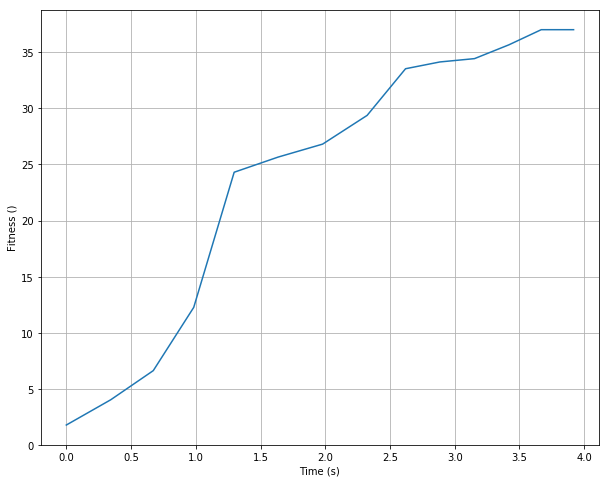

In [315]:
plot_fitness_time(mimic_4pks, '')

In [327]:
hc_4pks = hill_climbing(size, n_restarts, four_peaks, 'binary', T)
hc_4pks

initial fitness of start 1: 0
best fitness after start 1: 2
-------------------
initial fitness of start 2: 1
best fitness after start 2: 2
-------------------
initial fitness of start 3: 2
best fitness after start 3: 2
-------------------
initial fitness of start 4: 0
best fitness after start 4: 2
-------------------
initial fitness of start 5: 1
best fitness after start 5: 2
-------------------
initial fitness of start 6: 1
best fitness after start 6: 2
-------------------
initial fitness of start 7: 2
best fitness after start 7: 2
-------------------
initial fitness of start 8: 2
best fitness after start 8: 2
-------------------
initial fitness of start 9: 3
best fitness after start 9: 3
-------------------
initial fitness of start 10: 0
best fitness after start 10: 3
-------------------
initial fitness of start 11: 3
best fitness after start 11: 3
-------------------
initial fitness of start 12: 2
best fitness after start 12: 3
-------------------
initial fitness of start 13: 0
bes

[(0, array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]), 0.0),
 (2, array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]), 0.0),
 (3, array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]), 0.0),
 (4,
  array([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0]),
  0.015584230422973633),
 (23,
  array([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]),
  0.015584230422973633),
 (24,
  array([1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]),
  0.015584230422973633),
 (26,
  array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]),
  0.015584230422973633)]

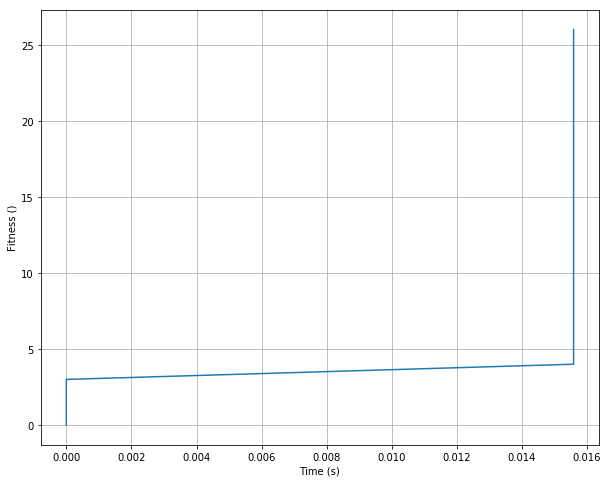

In [328]:
plot_fitness_time(hc_4pks, '')

In [318]:
sa_4pks = simulated_annealing(size, temp, final_temp, cooling_factor, four_peaks, 'binary', T)
sa_4pks

initial fitness: 1
best fitness after 1 iterations: 3
best fitness after 34 iterations: 6
best fitness after 40 iterations: 7
best fitness after 125 iterations: 24
best fitness after 152 iterations: 29
best fitness after 1068 iterations: 30
best fitness after 1554 iterations: 37


[(3, array([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]), 0.0),
 (6,
  array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]),
  0.015590906143188477),
 (7,
  array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]),
  0.015590906143188477),
 (24,
  array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0]),
  0.015590906143188477),
 (29,
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0]),
  0.015590906143188477),
 (30,
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]),
  0.015590906143188477),
 (37,
  array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  0.031239986419677734)]

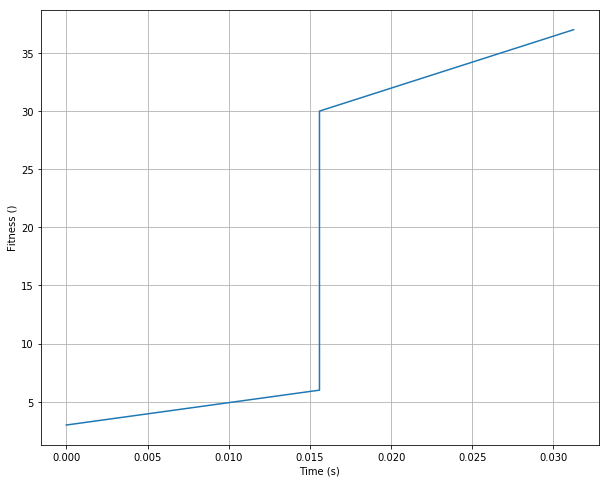

In [319]:
plot_fitness_time(sa_4pks, '')

In [320]:
ga_4pks = genetic_algorithm(size, pop_size, n_generations, mutation_rate, four_peaks, 'binary', T)
ga_4pks

initial fitness: 6
best fitness after generation 1: 25
best fitness after generation 2: 29
best fitness after generation 3: 31
best fitness after generation 4: 32
best fitness after generation 5: 32
best fitness after generation 6: 32
best fitness after generation 7: 33
best fitness after generation 8: 33
best fitness after generation 9: 36
best fitness after generation 10: 36
best fitness after generation 11: 36
best fitness after generation 12: 37
best fitness after generation 13: 37
best fitness after generation 14: 37
best fitness after generation 15: 37
best fitness after generation 16: 37
best fitness after generation 17: 37
best fitness after generation 18: 37
best fitness after generation 19: 37
best fitness after generation 20: 37


[(6, array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]), 0.0),
 (25,
  array([1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
         0., 0., 0.]),
  0.015621423721313477),
 (29,
  array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  0.03127002716064453),
 (31,
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
         0., 0., 0.]),
  0.03127002716064453),
 (32,
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         0., 0., 0.]),
  0.04689168930053711),
 (33,
  array([1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  0.09375357627868652),
 (36,
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 0., 0.]),
  0.1093754768371582),
 (37,
  array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 0.]),
  0.15623211860656738)]

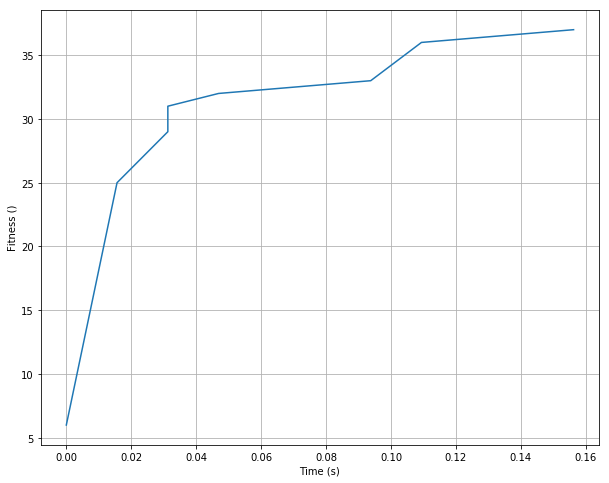

In [321]:
plot_fitness_time(ga_4pks, '')

# Max One

In [204]:
size = 50
n_restarts = 200
pop_size = 30
pct = 0.25
temp = 100
final_temp = 0.01
cooling_factor = 0.99
n_generations = 50
mutation_rate = 0.1
epsilon = 0.01

In [207]:
mimic_max1 = mimic(size, pop_size, pct, sum, 'binary', 0.01)
mimic_max1

initial average fitness: 24.033333333333335
average fitness after 1 iterations: 27.0
median fitness after 1 iterations: 27.0
average fitness after 2 iterations: 29.482758620689655
median fitness after 2 iterations: 29.0
average fitness after 3 iterations: 31.275862068965516
median fitness after 3 iterations: 31.0
average fitness after 4 iterations: 32.758620689655174
median fitness after 4 iterations: 33.0
average fitness after 5 iterations: 33.0
median fitness after 5 iterations: 33.0
average fitness after 6 iterations: 33.0
median fitness after 6 iterations: 33.0


[(24.033333333333335,
  array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
         1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
         1, 0, 1, 0, 1, 1]),
  0.0),
 (27.0,
  array([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
         0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 0]),
  0.21868658065795898),
 (29.482758620689655,
  array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
         0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 0, 1, 1, 0, 0]),
  0.4686274528503418),
 (31.275862068965516,
  array([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
         1, 0, 1, 1, 1, 0]),
  0.6547882556915283),
 (32.758620689655174,
  array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1,

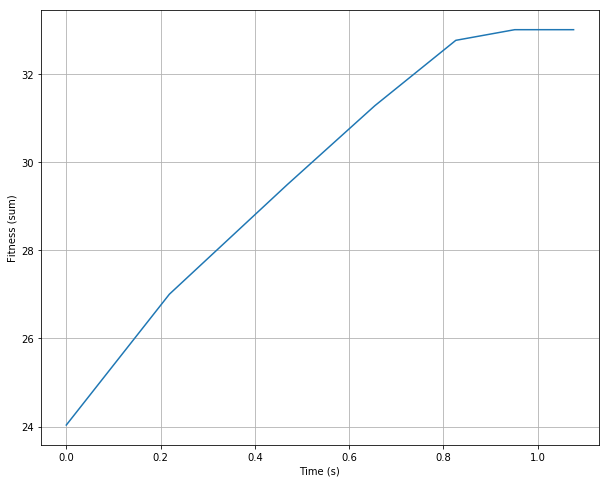

In [208]:
plot_fitness_time(mimic_max1, 'sum')

In [173]:
hc_max1 = hill_climbing(size, n_restarts, sum, 'binary')
hc_max1

initial fitness of start 1: 28
best fitness after start 1: 28
-------------------
initial fitness of start 2: 24
best fitness after start 2: 28
-------------------
initial fitness of start 3: 25
best fitness after start 3: 28
-------------------
initial fitness of start 4: 25
best fitness after start 4: 32
-------------------
initial fitness of start 5: 26
best fitness after start 5: 32
-------------------
initial fitness of start 6: 30
best fitness after start 6: 32
-------------------
initial fitness of start 7: 26
best fitness after start 7: 32
-------------------
initial fitness of start 8: 20
best fitness after start 8: 32
-------------------
initial fitness of start 9: 26
best fitness after start 9: 32
-------------------
initial fitness of start 10: 25
best fitness after start 10: 32
-------------------
initial fitness of start 11: 21
best fitness after start 11: 32
-------------------
initial fitness of start 12: 28
best fitness after start 12: 32
-------------------
initial fi

[(28, array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
         0, 1, 1, 1, 1, 1]), 0.0),
 (29, array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 0]), 0.0),
 (30, array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 0]), 0.0),
 (31, array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 0]), 0.0),
 (32, array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
         0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 0]), 0.0),
 (33, array([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 

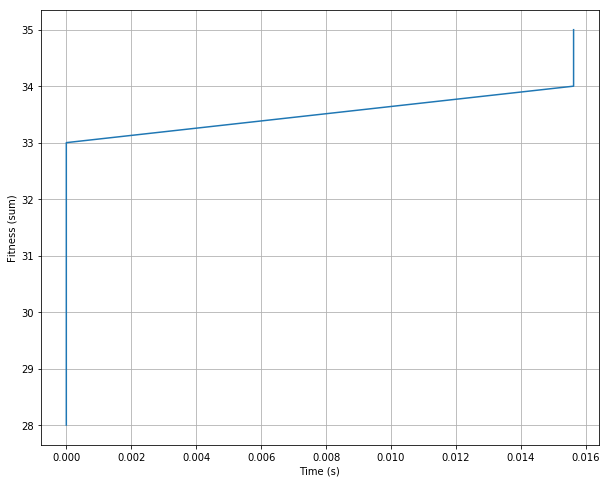

In [174]:
plot_fitness_time(hc_max1, 'sum')

In [184]:
sa_max1 = simulated_annealing(size, temp, final_temp, cooling_factor, sum, 'binary')
sa_max1

initial fitness: 24
best fitness after 0 iterations: 25
best fitness after 1 iterations: 26
best fitness after 2 iterations: 27
best fitness after 13 iterations: 28
best fitness after 14 iterations: 29
best fitness after 19 iterations: 30
best fitness after 20 iterations: 31
best fitness after 21 iterations: 32
best fitness after 40 iterations: 33
best fitness after 41 iterations: 34
best fitness after 296 iterations: 35
best fitness after 380 iterations: 36
best fitness after 426 iterations: 37
best fitness after 427 iterations: 38
best fitness after 428 iterations: 39
best fitness after 429 iterations: 40
best fitness after 430 iterations: 41
best fitness after 431 iterations: 42
best fitness after 434 iterations: 43
best fitness after 532 iterations: 44
best fitness after 571 iterations: 45
best fitness after 608 iterations: 46
best fitness after 618 iterations: 47
best fitness after 622 iterations: 48
best fitness after 643 iterations: 49
best fitness after 647 iterations: 50


[(25, array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 1, 0]), 0.0),
 (26, array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 1, 0]), 0.0),
 (27, array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 1, 0]), 0.0),
 (28, array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 1, 0, 1, 0]), 0.0),
 (29, array([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 1, 0, 1, 0]), 0.0),
 (30, array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 

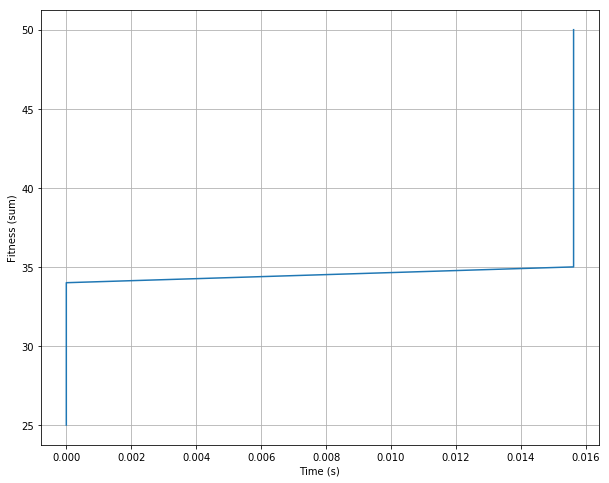

In [185]:
plot_fitness_time(sa_max1, 'sum')

In [205]:
ga_max1 = genetic_algorithm(size, pop_size, n_generations, mutation_rate, sum, 'binary')
ga_max1

initial fitness: 32
best fitness after generation 1: 37.0
best fitness after generation 2: 37.0
best fitness after generation 3: 37.0
best fitness after generation 4: 38.0
best fitness after generation 5: 40.0
best fitness after generation 6: 40.0
best fitness after generation 7: 41.0
best fitness after generation 8: 42.0
best fitness after generation 9: 43.0
best fitness after generation 10: 44.0
best fitness after generation 11: 44.0
best fitness after generation 12: 46.0
best fitness after generation 13: 46.0
best fitness after generation 14: 47.0
best fitness after generation 15: 48.0
best fitness after generation 16: 48.0
best fitness after generation 17: 49.0
best fitness after generation 18: 50.0
best fitness after generation 19: 50.0
best fitness after generation 20: 50.0
best fitness after generation 21: 50.0
best fitness after generation 22: 50.0
best fitness after generation 23: 50.0
best fitness after generation 24: 50.0
best fitness after generation 25: 50.0
best fitness a

[(32, array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
         1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
         1, 0, 1, 1, 1, 0]), 0.0),
 (37.0,
  array([1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
         0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.]),
  0.0),
 (38.0,
  array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.]),
  0.015619277954101562),
 (40.0,
  array([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.]),
  0.015619277954101562),
 (41.0,
  array([1., 1., 1., 1., 1., 1., 0

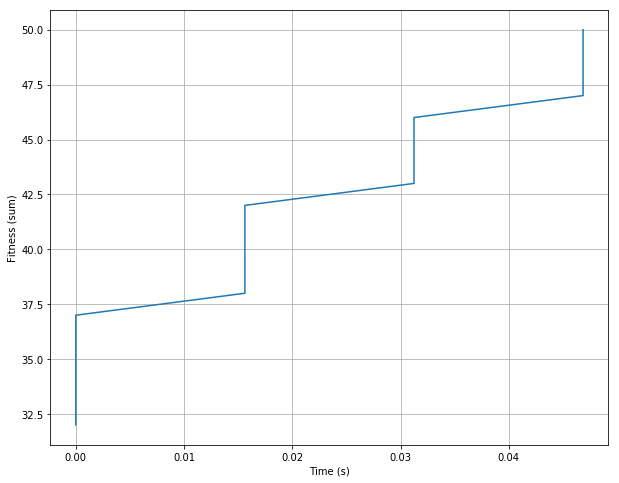

In [206]:
plot_fitness_time(ga_max1, 'sum')

# TSP

In [251]:
size = 10
n_restarts = 100
pop_size = 200
pct = 0.25
temp = 100
final_temp = 0.01
cooling_factor = 0.999
n_generations = 50
mutation_rate = 0.1
graph = create_graph('Cincinnati.tsp')

In [224]:
mimic_tsp = mimic(size, pop_size, pct, tsp_fitness, 'tsp', 0.00001, graph)
mimic_tsp

initial average fitness: 0.002696059871837107
average fitness after 1 iterations: 0.00284242158813666
average fitness after 2 iterations: 0.0029303677205481378
average fitness after 3 iterations: 0.0030319701054768587
average fitness after 4 iterations: 0.0031669971948991836
average fitness after 5 iterations: 0.003266410830498604
average fitness after 6 iterations: 0.003442538028547574
average fitness after 7 iterations: 0.003490718192543541
average fitness after 8 iterations: 0.003490718192543541


[(0.002696059871837107, array([ 9,  3,  2,  5,  1,  4, 10,  7,  6,  8]), 0.0),
 (0.00284242158813666,
  array([ 6,  4,  7,  1,  3,  9,  2,  5, 10,  8]),
  0.4842531681060791),
 (0.0029303677205481378,
  array([ 1,  8,  6,  4,  5,  7,  2,  3,  9, 10]),
  0.974372148513794),
 (0.0030319701054768587,
  array([ 1,  4,  6,  2,  9,  5,  3, 10,  7,  8]),
  1.4315152168273926),
 (0.0031669971948991836,
  array([ 8,  6,  5,  7,  4,  1, 10,  3,  2,  9]),
  1.8376703262329102),
 (0.003266410830498604,
  array([ 9,  4,  6,  5,  7,  3, 10,  1,  8,  2]),
  2.257030487060547),
 (0.003442538028547574,
  array([ 4,  8,  2,  7, 10,  1,  3,  5,  9,  6]),
  2.553845167160034),
 (0.003490718192543541,
  array([ 4,  8,  2,  1, 10,  3,  7,  5,  9,  6]),
  2.7568955421447754),
 (0.003490718192543541,
  array([ 4,  8,  2,  1, 10,  3,  7,  5,  9,  6]),
  2.975614309310913),
 (0.003490718192543541,
  array([ 4,  8,  2,  1, 10,  3,  7,  5,  9,  6]),
  2.975614309310913)]

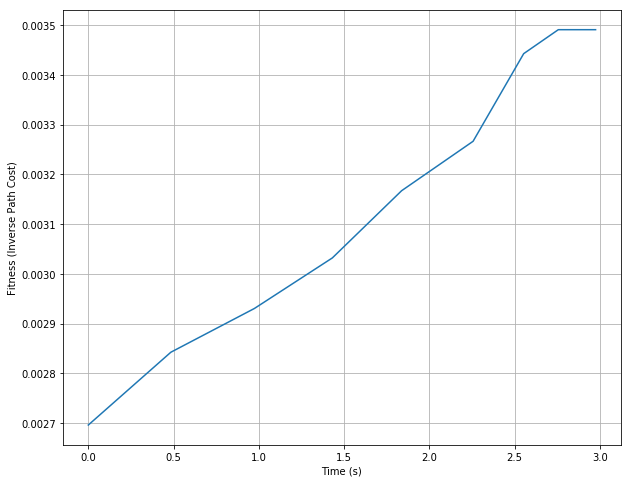

In [225]:
plot_fitness_time(mimic_tsp, 'Inverse Path Cost')

In [242]:
hc_tsp = hill_climbing(size, n_restarts, tsp_fitness, 'tsp', graph)
hc_tsp

initial fitness of start 1: 0.002804322072778092
best fitness after start 1: 0.002804322072778092
-------------------
initial fitness of start 2: 0.002780680777613153
best fitness after start 2: 0.002804322072778092
-------------------
initial fitness of start 3: 0.0031439974473758962
best fitness after start 3: 0.0031439974473758962
-------------------
initial fitness of start 4: 0.00276851862872094
best fitness after start 4: 0.0031439974473758962
-------------------
initial fitness of start 5: 0.003239323951925077
best fitness after start 5: 0.003239323951925077
-------------------
initial fitness of start 6: 0.0025816423681239184
best fitness after start 6: 0.003239323951925077
-------------------
initial fitness of start 7: 0.0028721705788080872
best fitness after start 7: 0.003239323951925077
-------------------
initial fitness of start 8: 0.002612527700990436
best fitness after start 8: 0.003239323951925077
-------------------
initial fitness of start 9: 0.002687354458761102
bes

[(0.002804322072778092, array([ 4,  5, 10,  1,  9,  2,  8,  7,  3,  6]), 0.0),
 (0.0031439974473758962, array([ 6,  8, 10,  3,  1,  5,  2,  9,  7,  4]), 0.0),
 (0.003239323951925077, array([ 5,  2,  8,  1, 10,  3,  6,  4,  7,  9]), 0.0),
 (0.003287975676003114,
  array([ 7,  4,  6,  8,  1,  9,  5,  2,  3, 10]),
  0.015592336654663086),
 (0.0033912411038335153,
  array([ 4,  2,  5,  9,  8,  1,  3, 10,  7,  6]),
  0.015592336654663086)]

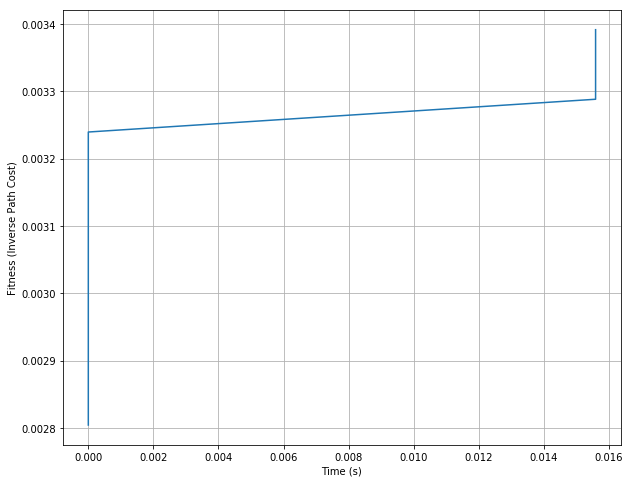

In [243]:
plot_fitness_time(hc_tsp, 'Inverse Path Cost')

In [228]:
sa_tsp = simulated_annealing(size, temp, final_temp, cooling_factor, tsp_fitness, 'tsp', graph)
sa_tsp

initial fitness: 0.0027096097322548457
best fitness after 0 iterations: 0.0027186951624742655
best fitness after 1 iterations: 0.0027390069967878953
best fitness after 5 iterations: 0.003011442321416087
best fitness after 21 iterations: 0.0031216885420604127
best fitness after 25 iterations: 0.0032266038599190845
best fitness after 26 iterations: 0.0032650243015432258
best fitness after 196 iterations: 0.0033172763336798508
best fitness after 798 iterations: 0.0034022845190573294
best fitness after 1395 iterations: 0.0035618511353525156
best fitness after 7565 iterations: 0.00357734020277094
best fitness after 8197 iterations: 0.0035773402027709407
best fitness after 8898 iterations: 0.003597735884366006


[(0.0027186951624742655, array([ 9,  2,  1,  7,  5,  4,  3, 10,  8,  6]), 0.0),
 (0.0027390069967878953, array([ 8,  2,  1,  7,  5,  4,  3, 10,  9,  6]), 0.0),
 (0.003011442321416087, array([10,  2,  1,  8,  5,  6,  4,  7,  9,  3]), 0.0),
 (0.0031216885420604127, array([10,  7,  9,  6,  4,  1,  8,  2,  5,  3]), 0.0),
 (0.0032266038599190845, array([ 2,  3,  7,  6,  4,  8,  1, 10,  5,  9]), 0.0),
 (0.0032650243015432258, array([ 2,  3,  5,  6,  4,  8,  1, 10,  7,  9]), 0.0),
 (0.0033172763336798508, array([ 2,  1,  9,  5,  8,  4,  6,  7, 10,  3]), 0.0),
 (0.0034022845190573294,
  array([ 5,  7, 10,  1,  3,  2,  4,  6,  8,  9]),
  0.031250953674316406),
 (0.0035618511353525156,
  array([ 5,  9,  8,  4,  6,  7, 10,  1,  3,  2]),
  0.06246519088745117),
 (0.00357734020277094,
  array([ 5,  8,  4,  6,  7, 10,  3,  1,  2,  9]),
  0.4061613082885742),
 (0.0035773402027709407,
  array([ 4,  6,  7, 10,  3,  1,  2,  9,  5,  8]),
  0.43740391731262207),
 (0.003597735884366006,
  array([ 4,  6,  7

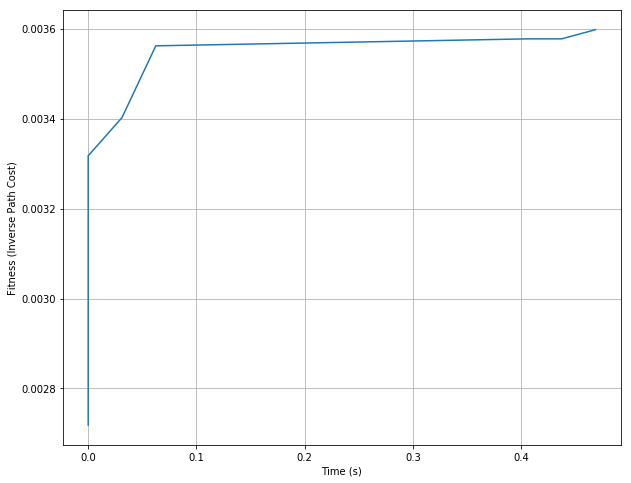

In [229]:
plot_fitness_time(sa_tsp, 'Inverse Path Cost')

In [290]:
ga_tsp = genetic_algorithm(size, pop_size, n_generations, mutation_rate, tsp_fitness, 'tsp', graph)
ga_tsp

initial fitness: 0.00338098802139611
best fitness after generation 1: 0.00338098802139611
best fitness after generation 2: 0.0033893976306944612
best fitness after generation 3: 0.0034809895052413226
best fitness after generation 4: 0.0035065132185624908
best fitness after generation 5: 0.0035065132185624908
best fitness after generation 6: 0.003541286155469262
best fitness after generation 7: 0.0035445742565603754
best fitness after generation 8: 0.0035619742140921545
best fitness after generation 9: 0.0035619742140921545
best fitness after generation 10: 0.0035619742140921545
best fitness after generation 11: 0.0035619742140921545
best fitness after generation 12: 0.0035619742140921545
best fitness after generation 13: 0.0035619742140921545
best fitness after generation 14: 0.003597735884366006
best fitness after generation 15: 0.003597735884366006
best fitness after generation 16: 0.003597735884366006
best fitness after generation 17: 0.003597735884366006
best fitness after generati

[(0.00338098802139611,
  array([ 5,  9,  4,  6,  7, 10,  3,  1,  2,  8]),
  0.015591621398925781),
 (0.0033893976306944612,
  array([ 6,  4,  8,  9,  2,  7, 10,  1,  3,  5]),
  0.0468599796295166),
 (0.0034809895052413226,
  array([ 6,  4,  8,  9,  2,  5,  3,  1, 10,  7]),
  0.0624845027923584),
 (0.0035065132185624908,
  array([ 6,  4,  8,  9,  2,  3,  1, 10,  7,  5]),
  0.07807564735412598),
 (0.003541286155469262,
  array([ 6,  4,  8,  9,  2,  1,  3, 10,  7,  5]),
  0.12727904319763184),
 (0.0035445742565603754,
  array([ 5,  9,  2,  6,  4,  8,  1,  3, 10,  7]),
  0.142927885055542),
 (0.0035619742140921545,
  array([ 8,  4,  6,  9,  2,  5,  7, 10,  3,  1]),
  0.15854096412658691),
 (0.003597735884366006,
  array([ 6,  4,  8,  9,  5,  2,  1,  3, 10,  7]),
  0.2835216522216797)]

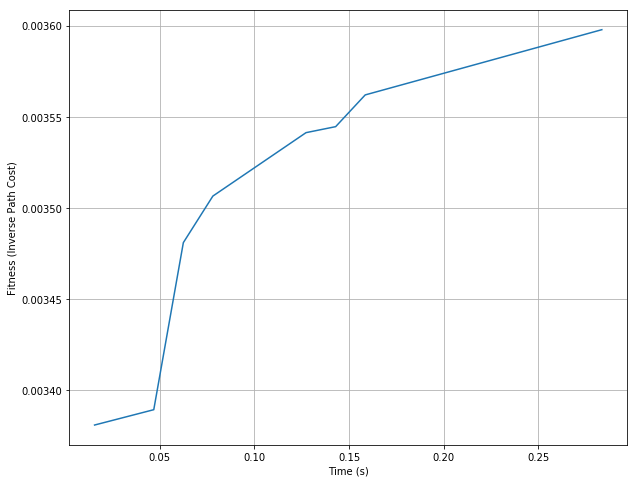

In [291]:
plot_fitness_time(ga_tsp, 'Inverse Path Cost')

In [292]:
print('MIMIC cost of TSP: {:.3f}'.format(1 / (mimic_tsp[-1][0] / 1000)))
print('Hill Climbing cost of TSP: {:.3f}'.format(1 / (hc_tsp[-1][0] / 1000)))
print('Simulated Annealing cost of TSP: {:.3f}'.format(1 / (sa_tsp[-1][0] / 1000)))
print('Genetic Algorithm cost of TSP: {:.3f}'.format(1 / (ga_tsp[-1][0] / 1000)))
print('Actual cost of TSP: {:.3f}'.format(277953))

MIMIC cost of TSP: 286473.999
Hill Climbing cost of TSP: 294877.294
Simulated Annealing cost of TSP: 277952.588
Genetic Algorithm cost of TSP: 277952.588
Actual cost of TSP: 277953.000


In [288]:
print('MIMIC path of TSP: {}'.format(mimic_tsp[-1][1]))
print('Hill Climbing path of TSP: {}'.format(hc_tsp[-1][1]))
print('Simulated Annealing cost of TSP: {}'.format(sa_tsp[-1][1]))
print('Genetic Algorithm cost of TSP: {}'.format(ga_tsp[-1][1]))

MIMIC path of TSP: [ 4  8  2  1 10  3  7  5  9  6]
Hill Climbing path of TSP: [ 4  2  5  9  8  1  3 10  7  6]
Simulated Annealing cost of TSP: [ 4  6  7 10  3  1  2  5  9  8]
Genetic Algorithm cost of TSP: [ 8  4  6  7 10  3  1  2  5  9]


In [289]:
print('MIMIC time of TSP: {}'.format(mimic_tsp[-1][2]))
print('Hill Climbing time of TSP: {}'.format(hc_tsp[-1][2]))
print('Simulated Annealing time of TSP: {}'.format(sa_tsp[-1][2]))
print('Genetic Algorithm time of TSP: {}'.format(ga_tsp[-1][2]))

MIMIC time of TSP: 2.975614309310913
Hill Climbing time of TSP: 0.015592336654663086
Simulated Annealing time of TSP: 0.4686470031738281
Genetic Algorithm time of TSP: 0.23430633544921875
